# Use Case for ARID1A Downstream Effects

In order to show more of what we can do with our mutation data, let's look at the gene ARID1A. ARID1A regulates transcription in certain genes by altering the chromatin structure around then. Mutations in ARID1A can therefore lead to significantly detrimental effects, especially in endometrial cancer. Attached here is a wikipedia article for a further introduction for ARID1A:
(https://en.wikipedia.org/wiki/ARID1A)

As we know, a mutation in a gene often causes significant funcional changes to the protein that it produces. We know that sometimes an alteration to that specific protein can cause immediate harmful effects to the cell. But in order to measure the mutation's complete effect, we also need to look at the proteins that interact with our mutated protein directly, as well as the ones that may be involved later on in a process that involves many proteins. This use case will show how to find some of those proteins, and how a mutation in our gene (ARID1A) affects them as well.

# Step 1: Import Libraries

Here we will import standard python libraries used to analyze and visualize data as pandas dataframes, as well as our CPTAC data.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

import cptac
import cptac.utils as al

en = cptac.Endometrial()
co = cptac.Colon()

gene = "ARID1A"

omics = "proteomics"
#omics = "transcriptomics"
#omics = "phosphoproteomics"
#omics = "acetylproteomics"

# Step 2: Get Interacting Proteins

Now we will get a list of the proteins that are know to interact with ARID1A directly. The method identified here, the bioplex method, is a process that includes tagging our protein of interest and then identifying the proteins around it that come into direct contact. When we call the get_interacting_proteins_bioplex method, this returns a list of proteins that interact with our gene in this way.

In [2]:
interacting_proteins = al.get_interacting_proteins_bioplex(gene)

print("Interacting Proteins:")
for interacting_protein in interacting_proteins:
    print(interacting_protein)

Interacting Proteins:
BCL7C
SMARCE1
BCL7A
DPF2
SS18
SMARCD1
SMARCC2
DPF3


# Step 3: Run T-tests to find significant comparisons

Now we create a new dataframe containing protein measurements for the interacting proteins that we are interested in. This is done with endometrial cancer, because we know that mutations in ARID1A have been shown to be especially important in endometrial cancer, but can also be done across all of the other cancers in the dataset. Later on in this use case we will show an example with colon cancr.

In [3]:
protdf = en.join_omics_to_mutations(mutations_genes=[gene], omics_df_name=omics, omics_genes=interacting_proteins)
protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']

Next, since in order to make comparisons we will want our "Label" column to contain one of two values- either "Mutated" or "Wildtype." We will then delete other columns

In [4]:
for ind, row in protdf.iterrows():
    if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
        protdf.at[ind,'Label'] = 'Mutated'
    else:
        protdf.at[ind,'Label'] = 'Wildtype'

In [5]:
protdf.head()

Name,BCL7C_proteomics,SMARCE1_proteomics,BCL7A_proteomics,DPF2_proteomics,SS18_proteomics,SMARCD1_proteomics,SMARCC2_proteomics,DPF3_proteomics,ARID1A_Mutation,ARID1A_Location,ARID1A_Mutation_Status,Sample_Status,Label
Sample_ID,,,,,,,,,,,,,
S001,-0.9180,-0.3950,0.4100,-0.548,-0.498,-0.328,-0.451,NaN,[Missense_Mutation],[p.T2121P],Single_mutation,Tumor,Mutated
S002,-0.9410,-0.5560,0.8880,-0.919,-0.162,-0.418,-0.627,NaN,"[Nonsense_Mutation, Frame_Shift_Del]","[p.Q403*, p.D1850Tfs*33]",Multiple_mutation,Tumor,Mutated
S003,-0.3880,-0.5400,0.0927,-0.555,-0.448,-0.648,-0.537,NaN,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor,Wildtype
S005,-0.0328,0.0968,0.6880,0.372,0.203,0.186,-0.102,NaN,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor,Wildtype
S006,-1.4000,0.0897,0.3460,-0.642,0.298,-0.599,-0.432,NaN,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor,Wildtype


Since we are only interested in interacting protein levels, here we trim down the dataframe and drop unwanted columns.

In [6]:
protdf = protdf.drop(gene+"_Mutation",axis=1)
protdf = protdf.drop(gene+"_Location",axis=1)
protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
protdf = protdf.drop("Sample_Status",axis=1)

We take the column names, which are the interacting proteins, and create a list in order to run our t-tests for each protein individually.

In [7]:
col_list = list(protdf.columns)
col_list.remove('Label')

In [8]:
print(col_list)

['BCL7C_proteomics', 'SMARCE1_proteomics', 'BCL7A_proteomics', 'DPF2_proteomics', 'SS18_proteomics', 'SMARCD1_proteomics', 'SMARCC2_proteomics', 'DPF3_proteomics']


Now we call wrap_ttest, which is an accessory function in cptac.utils. It expects one column with a binary variable (which is 'Label' for us as either mutated or wildtype), and all other data as qualitiative. It will then run ttests to determine if there is a statistically significant difference between the binary values and their respective qualitative data. For our case, it will tell us if there are significantly different measurements between wildtype and mutated samples.

In [9]:
print("Doing t-test comparisons\n")
wrap_results = al.wrap_ttest(protdf, 'Label', col_list)

if wrap_results is not None:
        print(wrap_results)
        print("\n\n")

Doing t-test comparisons

5 significant comparisons!
           Comparison       P_Value
0     DPF2_proteomics  2.166609e-07
1  SMARCC2_proteomics  8.270473e-05
2  SMARCE1_proteomics  1.498027e-04
3  SMARCD1_proteomics  1.744915e-04
4    BCL7C_proteomics  4.379537e-04





From this result, we now know that mutations in ARID1A significantly affect each of these protein values because of the small p-value. So among the list of proteins that we have that interact directly with ARIDIA, we know that these are the ones that are most affected when ARID1A is mutated.

# Step 4: Analyze collected proteins

Now that we have a list of affected proteins, we can do a further analysis on each of them. Here we will show an example using the protein DPF2, which functions as a transcription factor and regulates rapid hematopoietic cell growth. The tools shown here can be applied to any of the proteins that we found.

First we want to create and trim down a dataframe in order to easily graph our results. To do this, we simply want the sample ID, the protein level, and a label as to whether the sample is mutated or wildtype.

In [10]:
protdf = en.join_omics_to_mutations(omics_df_name='proteomics',omics_genes='DPF2',mutations_genes='ARID1A')
protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']

'''Create the binary valued column needed to do the comparison'''
for ind, row in protdf.iterrows():
    if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
        protdf.at[ind,'Label'] = 'Mutated'
    else:
        protdf.at[ind,'Label'] = 'Wildtype'

'''Format the dataframe correctly'''
protdf = protdf.drop(gene+"_Mutation",axis=1)
protdf = protdf.drop(gene+"_Location",axis=1)
protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
protdf = protdf.drop("Sample_Status",axis=1)

protdf.head()

Name,DPF2_proteomics,Label
Sample_ID,,
S001,-0.548,Mutated
S002,-0.919,Mutated
S003,-0.555,Wildtype
S005,0.372,Wildtype
S006,-0.642,Wildtype


Now we will plot our data using the seaborn library as a stripplot on top of a boxplot in order to see the distributions.

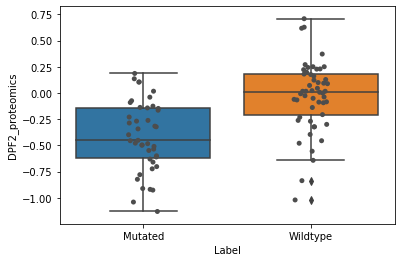

In [11]:
sns.boxplot(data = protdf, x = 'Label', y = 'DPF2_proteomics')
sns.stripplot(data = protdf, x = 'Label', y = 'DPF2_proteomics', jitter = True, dodge = True, color = '.3')

# Step 5: Find significant comparisons among all proteins

Earlier we found significantly altered protein levels among proteins that we already knew interacted closely with ARID1A. Now we will go through the rest of the proteins in the CPTAC dataset and find any more that were significantly changed because of a mutation in ARID1A. The reason for doing two separate comparisons is because multiple hypothesis correction requires a more stringent threshold if more data is being tested, so we often use a first pass of a small number of known interacting proteins and then a broader set. Here we will once again go through the same t-testing steps from earlier, but this time without specifying specific proteins.

In [12]:
print("\nGene: ", gene)

'''Use all proteins'''

'''Create dataframe in order to do comparisons with wrap_ttest'''
protdf = en.join_omics_to_mutations(mutations_genes=[gene], omics_df_name=omics) #Here is the different line
protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']
    
'''Create the binary valued column needed to do the comparison'''
for ind, row in protdf.iterrows():
    if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
        protdf.at[ind,'Label'] = 'Mutated'
    else:
        protdf.at[ind,'Label'] = 'Wildtype'

'''Format the dataframe correctly'''
protdf = protdf.drop(gene+"_Mutation",axis=1)
protdf = protdf.drop(gene+"_Location",axis=1)
protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
protdf = protdf.drop("Sample_Status",axis=1)

'''Make list of columns to be compared using t-tests'''
col_list = list(protdf.columns)
col_list.remove('Label')

print("Doing t-test comparisons\n")
    
'''Call wrap_ttest, pass in formatted dataframe'''
wrap_results = al.wrap_ttest(protdf, 'Label', col_list)

'''Print results, if anything significant was found'''
if wrap_results is not None:
        print(wrap_results)
        print("\n\n")


Gene:  ARID1A


Doing t-test comparisons



/Users/kimball.benjamin1/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/kimball.benjamin1/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


8 significant comparisons!
          Comparison       P_Value
0  ARID1A_proteomics  1.025018e-10
1   MAP1S_proteomics  1.010149e-07
2    DPF2_proteomics  2.166609e-07
3   KDM4B_proteomics  4.414547e-07
4    RRM1_proteomics  4.455870e-07
5  MAP7D3_proteomics  4.880890e-07
6   CYTH3_proteomics  3.109396e-06
7   CEP78_proteomics  3.749172e-06





As we see, as a result we got many of the same proteins from earlier, along with some new ones that we could analyze using the tools shown above.

# Step 6: Use the same tools on another cancer type

Now that we have looked at endometrial cancer, we will now use the same tools on colon cancer. We will find that there will not be any similar results. This goes to show how unique cancer types are, as around 20 percent of our colon cancer samples have mutations in ARID1A, but there are no similar downstream effects like we see in endometrial cancer.

In [13]:
'''Create dataframe in order to do comparisons with wrap_ttest'''
protdf = co.join_omics_to_mutations(mutations_genes=[gene], omics_df_name=omics, omics_genes=interacting_proteins)
protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']

'''Create the binary valued column needed to do the comparison'''
for ind, row in protdf.iterrows():
    if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
        protdf.at[ind,'Label'] = 'Mutated'
    else:
        protdf.at[ind,'Label'] = 'Wildtype'

'''Format the dataframe correctly'''
protdf = protdf.drop(gene+"_Mutation",axis=1)
protdf = protdf.drop(gene+"_Location",axis=1)
protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
protdf = protdf.drop("Sample_Status",axis=1)
#do groupby - if mutation to see how many

'''Make list of columns to be compared using t-tests'''
col_list = list(protdf.columns)
col_list.remove('Label')

print("Doing t-test comparisons\n")

'''Call wrap_ttest, pass in formatted dataframe'''
wrap_results = al.wrap_ttest(protdf, 'Label', col_list)

'''Print results, if anything significant was found'''
if wrap_results is not None:
        print(wrap_results)
        print("\n\n")

Doing t-test comparisons

No significant comparisons.


In [14]:
print("\nGene: ", gene)
    
'''Use all proteins'''
'''Create dataframe in order to do comparisons with wrap_ttest'''
protdf = co.join_omics_to_mutations(mutations_genes=[gene], omics_df_name=omics)
protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']
    
'''Create the binary valued column needed to do the comparison'''
for ind, row in protdf.iterrows():
    if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
        protdf.at[ind,'Label'] = 'Mutated'
    else:
        protdf.at[ind,'Label'] = 'Wildtype'

'''Format the dataframe correctly'''
protdf = protdf.drop(gene+"_Mutation",axis=1)
protdf = protdf.drop(gene+"_Location",axis=1)
protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
protdf = protdf.drop("Sample_Status",axis=1)

'''Make list of columns to be compared using t-tests'''
col_list = list(protdf.columns)
col_list.remove('Label')

print("Doing t-test comparisons\n")
    
'''Call wrap_ttest, pass in formatted dataframe'''
wrap_results = al.wrap_ttest(protdf, 'Label', col_list)

'''Print results, if anything significant was found'''
if wrap_results is not None:
        print(wrap_results)
        print("\n\n")


Gene:  ARID1A


Doing t-test comparisons

No significant comparisons.
